In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

windows = True # If on mac put false, windows true

#### Didnt have the important alpha factor in on the phi_baseline thing

Can i write something which checks if it is stable? Say check the difference between the final two values say?  
have a feeling there will be an error some where. maybe the way i calculate the resistance shouldnt be for all. think about the C line.  
have worked out that it has to be under 3 delay with any alpha value.

#### data input

In [2]:
if windows == True:
    baselines = pd.read_csv(r"C:\Users\timst\Onedrive - Nexus365\4YP\python\_storage\baselines\baselines_met.csv", index_col=0).rename(columns={"Q in single(µm3/s)": "baseline Q"}) # FOR WINDOWS
else:
    baselines = pd.read_csv(r"/Users/Debs/OneDrive - Nexus365/4YP/python/_storage/baselines\baselines_met.csv", index_col=0).rename(columns={"Q in single(µm3/s)": "baseline Q"}) # FOR MAC

#### paramaters

In [3]:
optimised_value_tau = 2.292929292929293
phi_min_baseline = 0.153
n=1
max_time = 140
no = 1501
delay_pressure_drop = 15

hill_constant = 2 # mmHg
time_for_drop = 30
ratio_drop = 0.5

#### work out vectors

In [4]:
t = pd.Series(np.linspace(0,max_time,no))
dt = max_time/(no-1)
drop_value = 60 - 34.18*ratio_drop

#### PRessure stuff
pressure_in = pd.Series(np.zeros(len(t)))
for i in range(len(t)):
    if t[i] <= delay_pressure_drop:
        pressure_in[i] = 60
    elif t[i] <= delay_pressure_drop + time_for_drop:
        pressure_in[i] = 60 - ((t[i] - delay_pressure_drop)/time_for_drop)*(60-drop_value)
    else:
        pressure_in[i] = drop_value
pressure_out = pd.Series(np.zeros(len(t))) + 60 - 34.18
pressure_difference = pressure_in - pressure_out

print('Time of simulation :',max_time,'seconds')
print('Time step :',dt,'seconds')
print('Number of iterations:',no)

Time of simulation : 140 seconds
Time step : 0.09333333333333334 seconds
Number of iterations: 1501


## Model

#### Functions

In [5]:
def total_R(baselines,phi,alpha):
    C_ = alpha*(baselines.loc[6,'Resistance for Q']/2)/phi**4  + (1-alpha)*(baselines.loc[6,'Resistance for Q']/2)
    C_6 = (C_ + baselines.loc[5,'Resistance for Q'] + baselines.loc[7,'Resistance for Q'])/2
    C_65 = (C_6 + baselines.loc[4,'Resistance for Q'] + baselines.loc[8,'Resistance for Q'])/2
    C_654 = (C_65 + baselines.loc[3,'Resistance for Q'] + baselines.loc[9,'Resistance for Q'])/2
    C_6543 = (C_654 + baselines.loc[2,'Resistance for Q'] + baselines.loc[10,'Resistance for Q'])/2
    C_65432 = (C_6543 + baselines.loc[1,'Resistance for Q'] + baselines.loc[11,'Resistance for Q'])/2
    C_654321 = C_65432 + baselines.loc[0,'Resistance for Q'] + baselines.loc[12,'Resistance for Q']
    R_total = C_654321
    return R_total

def euler(alpha,delay):
    delay_number = round(delay/dt)
    
    R_tot = pd.Series(np.zeros(len(t)))
    Q_tot = pd.Series(np.zeros(len(t)))
    Q_norm = pd.Series(np.ones(len(t)))
    
    phi = pd.Series(np.ones(no))
    phi_min = pd.Series(np.ones(no))
    dphidt = pd.Series(np.zeros(no))
    
    for i in range(len(t)):
        
        if i >=delay_number: 
            R_tot[i] = total_R(baselines,phi[i],alpha)
            Q_tot[i] = pressure_difference[i]/R_tot[i]
            Q_norm[i] = Q_tot[i] / baselines['baseline Q'][0]
            dphidt[i] =  (1/optimised_value_tau)*( -phi[i-delay_number] + Q_norm[i]*(1-phi_min[i]) + phi_min[i] )
            phi[i+1] = dphidt[i]*dt + phi[i]
            phi_min[i+1] = 1-(alpha**0.25)*(1-phi_min_baseline)*(1-Q_norm[i])**n
            
    combined = pd.DataFrame()
    combined['t'] = t
    combined['pressure_difference'] = pressure_difference
    combined['phi'] = phi
    combined['phi_min'] = phi_min
    combined['dphidt'] = dphidt
    combined['R_tot'] = R_tot
    combined['Q_tot'] = Q_tot
    combined['Q_norm'] = Q_norm
            
    return combined

#### the loop

In [6]:
response = {}
detail = 10
alpha = np.linspace(0,1,num=detail)
delay = np.linspace(0,10, num=detail)

yay_or_nay = pd.DataFrame()

for i in tqdm(range(len(alpha))):
    for j in range(len(delay)):
        #first is alpha second is delay
        response[i,j] = euler(alpha[i],delay[j])
        if len(response[i,j][response[i,j]['phi'] < 0]) == 0:
            yay_or_nay.loc[alpha[i],delay[j]] = 1
        else:
            yay_or_nay.loc[alpha[i],delay[j]] = 0
yay_or_nay.index.name = 'alpha'
yay_or_nay = yay_or_nay.rename_axis('delay', axis=1)

100%|██████████| 10/10 [01:32<00:00,  9.29s/it]


In [ ]:
#first is alpha second is delay
for i in range(detail):
    for j in range(detail):
        if yay_or_nay.iloc[i,j] != 1:
            yay_or_nay.iloc[i,j] = 

In [8]:
yay_or_nay.iloc[0,0] == 1

True

#### graphs

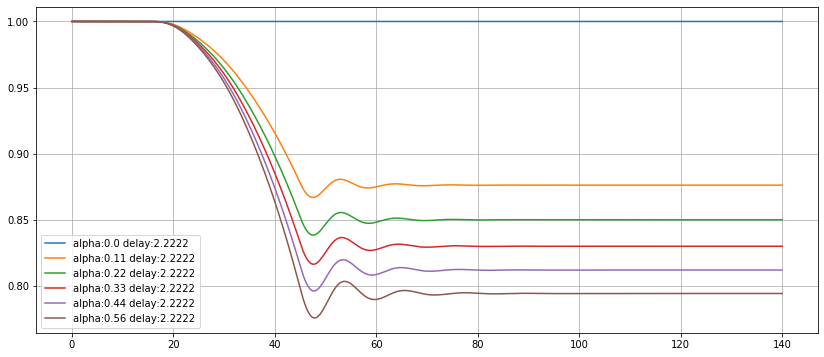

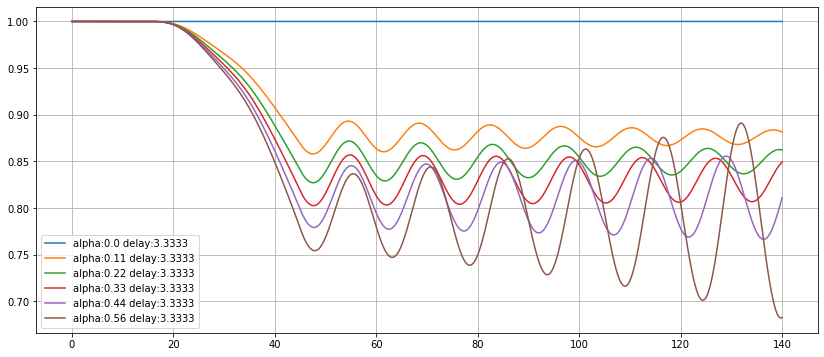

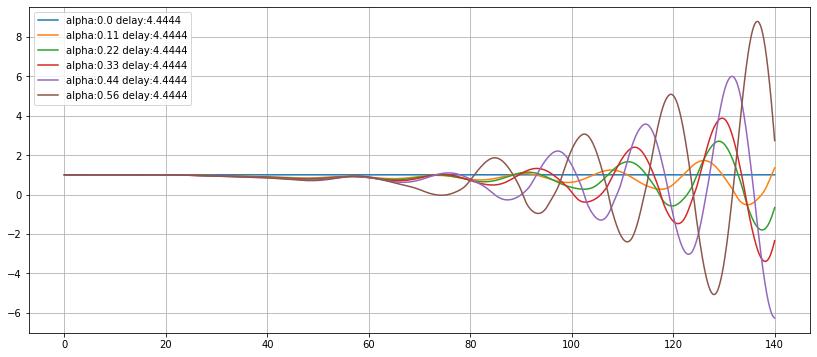

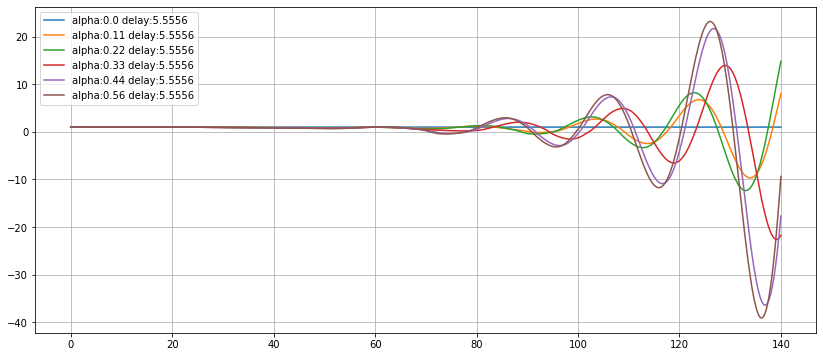

In [10]:

###Select which graphs
#put alpha in or delay in if you want the whole range
# delay_graph = [0,3,4,8,9]
# alpha_graph = [0,1,2,3,4,5,6,7,8,9]
delay_graph = [2,3,4,5]
alpha_graph = [0,1,2,3,4,5]

fig={}
ax={}
# fig,ax = plt.subplots(figsize=(14,6))
# fig = plt.grid(which='both')
for i in range(len(delay_graph)):
    fig[i],ax[i] = plt.subplots(figsize=(14,6))
    fig[i] = plt.grid(which='both')
    for j in range(len(alpha_graph)):
        ax[i] = plt.plot(response[alpha_graph[j],delay_graph[i]]['t'],response[alpha_graph[j],delay_graph[i]]['phi'][0:len(t)],label='alpha:{} delay:{}' .format(round(alpha[alpha_graph[j]], ndigits=2),round(delay[delay_graph[i]], ndigits=4)))
    fig[i] = plt.legend()